In [9]:
from   pyfirmata		 import Arduino, util
from   scipy.integrate   import odeint

import time
import numpy             as np
import matplotlib.pyplot as plt

# Controlo PID de sistemas térmicos

O objetivo do trabalho é controlar a temperatura do sistema SERT usando um controlador proporcional, integral e derivativo (**PID**). 

## 1. Introdução
Uma primeira abordagem ao controlo poderá ser usar um simples controlador ON/OFF onde o sistema está totalmente a ON quando o erro é positivo (máxima potência) e totalmente a OFF quando o erro é negativo (potência nula). Uma abordagem mais adequada para o controlo é modular a potência do sistema na proporção do erro de temperatura existente e/ou da integral do erro e/ou da derivada do erro. Ou seja, se o sistema estiver a uma temperatura muita baixa (erro elevado), o sistema é colocado a ON durante mais tempo (mais potência), mas se este estiver a uma temperatura não tão baixa (erro mais pequeno), coloca-se o sistema durante menos tempo em ON (menos potência). Um tipo de controlador que fornece a soma de três ações de controlo, nomeadamente a ação proporcional ($P$), a ação integral ($I$) e a ação derivativa ($D$), é o chamado controlo Proporcional, Integral e Derivativo, ou simplesmente controlo **PID**. Matematicamente, é expresso por:

$$ u(t)=K_p\left(e(t) + \frac{1}{T_i}\int_{0}^{t}e(\tau) d\tau+T_d\frac{de(t)}{dt} \right) \tag{1} $$

em que $K_p$ é o ganho proporcional, $T_i$ a constante de tempo integral, e $T_d$ a constante de tempo derivativa. 

Uma outra forma de representar um controlador PID é dada por:

$$ u(t)=K_p e(t) + K_i\int_{0}^{t}e(\tau) d\tau + K_d\frac{de(t)}{dt} = P(t) + I(t) + D(t) \tag{2} $$

onde $K_i=K_p⁄T_i$ é o ganho integral e $K_d=K_p T_d$ o ganho derivativo. $P$, $I$ e $D$ são respetivamente os termos proporcional, integral e derivativo. Embora as duas formas (1) e (2) sejam equivalentes, os valores dos parâmetros são muito diferentes.

A correspondente função de transferência do controlador **PID** é:

$$ C(s)=\frac{U(s)}{E(s)} = K_p\left(1 + \frac{1}{T_i s} + T_d s \right) = K_p + \frac{K_i}{s} + K_d s \tag{3} $$

## 2. Controlo do Sistema Térmico
Considere para as experiências seguintes uma temperatura de referência de $T_{ref}=50$ °C e um período de amostragem de $T=1$ s. 

### 2.1 Controlo P
Um tipo de controlador em que o sinal de controlo é proporcional ao erro da temperatura é o chamado controlo Proporcional ou controlo **P**. Este pode ser obtido através da equação (2) colocando os parâmetros $K_i=K_d=0$, resultando:

$$ u(t) = K_p e(t) $$

O algoritmo de controlo do controlador **P** é dado por:

$$ v(k) = K_p e(k)$$
$$ u(k) = sat(v(k),u_{min},u_{max})$$

em que $sat(\cdot )$ é a função de saturação que adapta os valores do sinal de controlo para os limites do atuador, $u_{min}$ e $u_{max}$. 

A figura seguinte apresenta o diagrama de blocos do sistema em malha fechada com um controlador **P**.

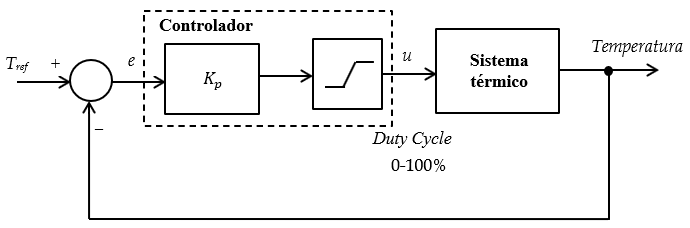

In [10]:
class ArduinoBoard():
    
    def __init__(self):
#Porta COM #### AJUSTAR porta ####
        board = Arduino('COM5')

        iterator = util.Iterator(board)
        iterator.start()

# Entradas analógicas
        self.T_S1 = board.get_pin('a:0:i') # A0
        self.T_S2 = board.get_pin('a:1:i') # A1

# Saídas PWM
        self.S1 = board.get_pin('d:10:p')  # Pino 10
        self.S2 = board.get_pin('d:9:p')   # Pino 9

        time.sleep(1)

# Função de conversão ADC - Temperatura
    def TEMP(self,val):
        return (val*5000.0-500.0)/10.0

# Funções temperaturas
    def T1(self):
        return self.TEMP(self.T_S1.read())
    
    def T2(self):
        return self.TEMP(self.T_S2.read())
    
    def write_S1(self, value):
        self.S1.write(value)
    
    def write_S2(self, value):
        self.S2.write(value)
    
    def endCom(self):
        self.S1.write(0.0)
        self.S2.write(0.0)
        #self.board.exit()


Para as experiências com o controlador **P** utilize o sistema térmico 1 (sensor `S1`) do SERT. Neste caso, efetue o controlo do sistema durante um tempo de $t_{final}=200$ s. 

In [ ]:
arduino=ArduinoBoard()
PeriodAmost   = 1 										# Periodo de Amostragem 
FinalTime     = 200.0									# Tempo de experiência
Amostras      = int(np.round(FinalTime/PeriodAmost+1))	# Numero de amostras
SinalControlo = np.zeros(Amostras)						# Lista para recolher info sobre Sinal de Controlo aplicado
YModelo       = np.ones(Amostras)*25.0					# Lista para recolher info sobre a variação de temperatura
Erro          = np.zeros(Amostras)						# Lista para recolher info sobre a variação de erro
TRef     	  = np.ones(Amostras)*50.0					# Lista que contem a temperatura de referencia
TInicial 	  = 23.0									# Temperatura inicial para fins de simulação
K   		  = 0.667									# Ganho do sistema obtido no guião anterior
tau 		  = 143.552									# Tau do sistema obtido no guião anterior
tauD 		  = 100.654									# TauD do sistema obtido no guião anterior


def ControloP(Kp, ErrorValue) :
    return Kp * ErrorValue 

def Saturacao(Kp, Error):
    return min(100, max(0, ControloP(Kp, Error)))

def ControloP1(Kp):
    for i in range(Amostras-1):

        YModelo[i] = arduino.T1()

        Erro[i] = TRef[i] - YModelo[i]

        SinalControlo[i] = Saturacao(Kp, Erro[i])
            
        arduino.write_S1(SinalControlo[i]/100)

        time.sleep(PeriodAmost)
        
    return TRef, YModelo, SinalControlo, Erro

#### Ponto 1
Obtenha o comportamento do sistema **SERT** com um controlador **P** para o seguinte conjunto de quatro valores arbitrários para o ganho proporcional: $K_p=1,5,10,20$.

**a)**

Apresente as curvas de resposta da temperatura do sistema térmico e dos correspondentes sinais de controlo ($u$, em termos do *Duty Cycle*) para os vários valores do ganho $K_p$ considerados. Mostre também um gráfico do erro $e$ ao longo do tempo entre a temperatura de referência $T_{ref}$ e a temperatura atual do sistema.

In [ ]:
#---------------------------------------------------#
#		  Controlo P para Sistema Sem Atraso  		#
#---------------------------------------------------#

Kp = [1,5, 10, 20]

print(f"Starting Kp = {Kp[0]}")

import copy

TRefKp0, YModeloKp0, SinalControloKp0, ErroKp0 = map(copy.deepcopy, ControloP1(Kp[0]))

temp = 1000

'''
	Certificar que a próxima experiência ocorre com valor de temperatura perto da temperatura inicial
'''
arduino.write_S1(0)
while(temp > 23):
    time.sleep(1)
    temp = arduino.T1()
    print(f"Temp = {temp}")

arduino.write_S1(0)

while(arduino.T2() > 25):
	time.sleep(1)

TRefKp1, YModeloKp1, SinalControloKp1, ErroKp1 = map(copy.deepcopy, ControloP1(Kp[1]))

temp = arduino.T1()
arduino.write_S1(0)

while(temp > 23):
    time.sleep(1)
    temp = arduino.T1()
    print(f"Temp = {temp}")

TRefKp2, YModeloKp2, SinalControloKp2, ErroKp2 = map(copy.deepcopy, ControloP1(Kp[2]))

temp = arduino.T1()
arduino.write_S1(0)

while(temp > 23):
    time.sleep(1)
    temp = arduino.T1()
    print(f"Temp = {temp}")

print(f"Starting Kp = {Kp[3]}")
TRefKp3, YModeloKp3, SinalControloKp3, ErroKp3 = map(copy.deepcopy, ControloP1(Kp[3]))

arduino.endCom()

dados = np.vstack((TRefKp0, YModeloKp0, SinalControloKp0, ErroKp0)).T
np.savetxt(f"./ControloP_Kp0.txt", dados, delimiter=',', header = 'coisas para dar skip',comments='')
dados = np.vstack((TRefKp1, YModeloKp1, SinalControloKp1, ErroKp1)).T
np.savetxt(f"./ControloP_Kp1.txt", dados, delimiter=',', header = 'coisas para dar skip',comments='')
dados = np.vstack((TRefKp2, YModeloKp2, SinalControloKp2, ErroKp2)).T
np.savetxt(f"./ControloP_Kp2.txt", dados, delimiter=',', header = 'coisas para dar skip',comments='')
dados = np.vstack((TRefKp3, YModeloKp3, SinalControloKp3, ErroKp3)).T
np.savetxt(f"./ControloP_Kp3.txt", dados, delimiter=',', header = 'coisas para dar skip',comments='')


plt.figure(1)
ax = plt.subplot(2,1,1)
ax.grid()
plt.plot(YModeloKp0, '#4FFF33', linewidth = 2, label='Kp=1')
plt.plot(YModeloKp1, '#33A5FF', linewidth = 2, label='Kp=5')
plt.plot(YModeloKp2, '#B533FF', linewidth = 2, label='Kp=10')
plt.plot(YModeloKp3, '#ffff00', linewidth = 2, label='Kp=20')
plt.plot(TRefKp2, 'k-', linewidth = 2, label='Temperatura Referência')
plt.ylabel('Temperatura ($^oC$)')
plt.legend(loc='best')

ax = plt.subplot(2,1,2)
ax.grid()
plt.plot(SinalControloKp0,'#4FFF33',label='Sinal Controlo Kp=1')
plt.plot(SinalControloKp1,'#33A5FF',label='Sinal Controlo Kp=5')
plt.plot(SinalControloKp2,'#B533FF',label='Sinal Controlo Kp=10')
plt.plot(SinalControloKp3,'#ffff00',label='Sinal Controlo Kp=20')
plt.ylabel('Sinal de Controlo ($\%$)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.savefig(f"./SERTCompKps.png")
plt.close()

plt.figure(2)
plt.grid()
plt.plot(ErroKp0, '#4FFF33', linewidth = 2, label = "Erro Kp=1")
plt.plot(ErroKp1, '#33A5FF', linewidth = 2, label = "Erro Kp=5")
plt.plot(ErroKp2, '#B533FF', linewidth = 2, label = "Erro Kp=10")
plt.plot(ErroKp3, '#ffff00', linewidth = 2, label = "Erro Kp=20")
plt.ylabel('Erro ($\%$)')
plt.legend(loc='best')
plt.xlabel('Tempo (s)')
plt.savefig(f"./SERTCompErrosKp.png")
plt.close()

Starting Kp = 1
KP = 1
Iteration 0:
  YModelo[0] = 23.3
  Erro[0] = 26.7
  SinalControlo[0] = 26.7
  SinalControlo[0] (scaled) = 0.267
KP = 1
Iteration 1:
  YModelo[1] = 23.3
  Erro[1] = 26.7
  SinalControlo[1] = 26.7
  SinalControlo[1] (scaled) = 0.267
KP = 1
Iteration 2:
  YModelo[2] = 23.3
  Erro[2] = 26.7
  SinalControlo[2] = 26.7
  SinalControlo[2] (scaled) = 0.267
KP = 1
Iteration 3:
  YModelo[3] = 23.3
  Erro[3] = 26.7
  SinalControlo[3] = 26.7
  SinalControlo[3] (scaled) = 0.267
KP = 1
Iteration 4:
  YModelo[4] = 23.3
  Erro[4] = 26.7
  SinalControlo[4] = 26.7
  SinalControlo[4] (scaled) = 0.267
KP = 1
Iteration 5:
  YModelo[5] = 23.3
  Erro[5] = 26.7
  SinalControlo[5] = 26.7
  SinalControlo[5] (scaled) = 0.267
KP = 1
Iteration 6:
  YModelo[6] = 23.8
  Erro[6] = 26.2
  SinalControlo[6] = 26.2
  SinalControlo[6] (scaled) = 0.262
KP = 1
Iteration 7:
  YModelo[7] = 23.8
  Erro[7] = 26.2
  SinalControlo[7] = 26.2
  SinalControlo[7] (scaled) = 0.262
KP = 1
Iteration 8:
  YModelo[8]

**b)**

As curvas de temperatura apresentam o comportamento desejado? Refira-se tanto ao comportamento transitório como ao do regime permanente. Justifique considerando os vários valores do ganho $K_p$ utilizados e na análise dos seguintes parâmetros:
* Valores do erro em regime permanente do sistema, $e_{ss}$
* Sinais de controlo, $u$ 

In [ ]:
# Insira os comentários AQUI




#### Ponto 2
Simule o sistema de controlo em malha fechada da temperatura usando um o controlador **P**, $C(s)=K_p$, conforme representado na figura seguinte. 

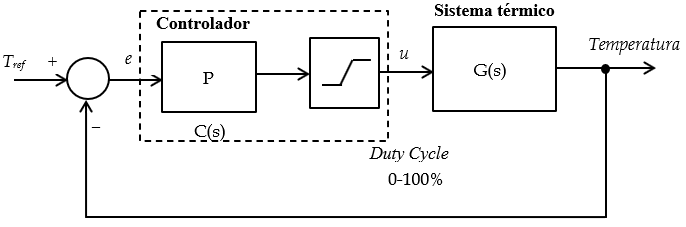

Para isso, utilize o modelo de primeira ordem identificado no Guião do Trabalho No. 1, com a função de transferência:

$$ G(s)=\frac{Y(s)}{U(s)}=\frac{K}{τs+1} $$

e os parâmetros $(K,\tau)$ identificados do sistema SERT (sensor `S1`). 

A correspondente equação diferencial é dada por:

$$ \tau \frac{dy(t)}{dt} + y(t) = K u(t)$$ 

**a)**

Apresente as curvas de resposta da temperatura do sistema simulado e dos correspondentes sinais de controlo ($u$) para os ganhos do controlador **P** considerados no **Ponto 1**: $K_p=1,5,10,20$. Mostre também um gráfico do erro ao longo do tempo entre a referência de temperatura $T_{ref}$ e a temperatura simulada do sistema.

Realizar importação das bibliotecas utilizadas

In [13]:
#Carregar Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Definição do Modelo

In [19]:
# parâmetros do modelo
PeriodAmost   = 1 										# Periodo de Amostragem 
FinalTime     = 200.0									# Tempo de experiência
Amostras      = int(np.round(FinalTime/PeriodAmost+1))	# Numero de amostras
SinalControlo = np.zeros(Amostras)						# Lista para recolher info sobre Sinal de Controlo aplicado
YModelo       = np.ones(Amostras)*25.0					# Lista para recolher info sobre a variação de temperatura
Erro          = np.zeros(Amostras)						# Lista para recolher info sobre a variação de erro
TRef     	  = np.ones(Amostras)*50.0					# Lista que contem a temperatura de referencia
TInicial 	  = 23.0									# Temperatura inicial para fins de simulação
K   		  = 0.667									# Ganho do sistema obtido no guião anterior
tau 		  = 143.552									# Tau do sistema obtido no guião anterior
t = np.linspace(0,FinalTime,Amostras)                   # vetor dos tempos

# definir modelo 
def modelo(y, t, u, k, tau):
    dydt = -(y-TInicial)/tau + (k/tau) * u
    return dydt

def ControloP(Kp, ErrorValue) :
    return Kp * ErrorValue

def Saturacao(Kp, Error):
    return min(100, max(0, ControloP(Kp, Error)))

def ControloSimulacao(Amostras,PeriodAmost,YModelo,SinalControlo,Erro,TInicial,K,tau,Kp):
    for i in range(Amostras-1):

        #Erro
        Erro[i] = TRef[i] - YModelo[i]

        #Controlo P
        SinalControlo[i] = Saturacao(Kp, Erro[i])

        #Simulação de Temperatura
        YSimulado = odeint(modelo,TInicial,[0,PeriodAmost],args=(SinalControlo[i],K,tau))
        print(YSimulado, Kp)
        TInicial = YSimulado[1]; # Define nova condição inicial
    
        YModelo[i+1] = YSimulado[1]  # guarda temperatura

        SinalControlo = np.resize(SinalControlo, SinalControlo.size - 1)    
        SinalControlo = np.append(SinalControlo,SinalControlo[SinalControlo.size - 1])

        Erro = np.resize(Erro, Erro.size - 1)    
        Erro = np.append(Erro,Erro[Erro.size - 1])
        DadosSim = np.array([Erro,SinalControlo,YModelo])

        return DadosSim



In [20]:
# ganho do controlador P
Kp = [1,5, 10, 20]

DadosSim1 = ControloSimulacao(Amostras,PeriodAmost,YModelo,SinalControlo,Erro,TInicial,K,tau,Kp[0])
DadosSim5 = ControloSimulacao(Amostras,PeriodAmost,YModelo,SinalControlo,Erro,TInicial,K,tau,Kp[1])
DadosSim10 = ControloSimulacao(Amostras,PeriodAmost,YModelo,SinalControlo,Erro,TInicial,K,tau,Kp[2])
DadosSim20 = ControloSimulacao(Amostras,PeriodAmost,YModelo,SinalControlo,Erro,TInicial,K,tau,Kp[3])

[[23.        ]
 [23.11575654]] 1
[[23.        ]
 [23.46302564]] 5
[[23.        ]
 [23.46302564]] 10
[[23.        ]
 [23.46302564]] 20


C:\Users\lucia\AppData\Local\Temp\ipykernel_15472\1643128585.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  YModelo[i+1] = YSimulado[1]  # guarda temperatura


Grafico de resposta da Simulação

<Figure size 640x480 with 0 Axes>

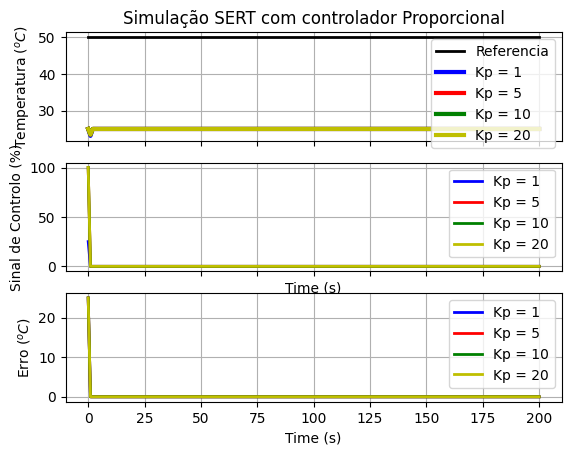

In [18]:
plt.figure(1)

fig, (ax1, ax2,ax3) = plt.subplots(3, sharex=True)
ax1.set_title('Simulação SERT com controlador Proporcional')
ax1 = plt.subplot(3,1,1)
ax1.grid()
plt.plot(t,TRef,'k-',linewidth=2,label='Referencia')
plt.plot(t,DadosSim1[2],'b-',linewidth=3,label='Kp = 1')
plt.plot(t,DadosSim5[2],'r-',linewidth=3,label='Kp = 5')
plt.plot(t,DadosSim10[2],'g-',linewidth=3,label='Kp = 10')
plt.plot(t,DadosSim20[2],'y-',linewidth=3,label='Kp = 20')

plt.ylabel('Temperatura ($^oC$)')
plt.legend(loc='best')

# controlo u
ax2 = plt.subplot(3,1,2)
ax2.grid()
plt.plot(t,DadosSim1[1],'b-',linewidth=2,label='Kp = 1')
plt.plot(t,DadosSim5[1],'r-',linewidth=2,label='Kp = 5')
plt.plot(t,DadosSim10[1],'g-',linewidth=2,label='Kp = 10')
plt.plot(t,DadosSim20[1],'y-',linewidth=2,label='Kp = 20')
plt.ylabel('Sinal de Controlo (%)')
plt.xlabel('Time (s)')
plt.legend(loc='best')

# erro e
ax2 = plt.subplot(3,1,3)
ax2.grid()
plt.plot(t,DadosSim1[0],'b-',linewidth=2,label='Kp = 1')
plt.plot(t,DadosSim5[0],'r-',linewidth=2,label='Kp = 5')
plt.plot(t,DadosSim10[0],'g-',linewidth=2,label='Kp = 10')
plt.plot(t,DadosSim20[0],'y-',linewidth=2,label='Kp = 20')
plt.ylabel('Erro ($^oC$)')
plt.xlabel('Time (s)')
plt.legend(loc='best')

plt.show()

**b)**

Compare as curvas de simulação (temperatura e sinal de controlo) obtidas em **a)** com as respostas experimentais do **Ponto 1**. Comente eventuais diferenças existentes entre ambas as respostas. 

In [ ]:
# Coloque o código/comentários AQUI




### 2.2	Controlo PI

Adicionando o controlo $P$ à integral do erro ($I$) obtemos o chamado controlo Proporcional e Integral ou simplesmente controlo **PI**. Este pode ser obtido através da equação (2) colocando o parâmetro $K_d=0$, resultando:

$$ u(t)=K_p\left(e(t) + \frac{1}{T_i}\int_{0}^{t}e(\tau) d\tau \right) =  K_p e(t) + \frac{K_p}{T_i}\int_{0}^{t}e(\tau) d\tau = P(t) + I(t) $$

Um possível algoritmo de controlo do controlador **PI** é dado por:

$$ P(k) = K_p e(k)$$
$$ v(k) = P(k) + I(k)$$
$$ u(k) = sat(v(k),u_{min},u_{max})$$
$$I(k+1) = I(k) + \frac{K_P T}{T_i}  e(k)$$


A figura seguinte apresenta o diagrama de blocos do sistema em malha fechada com um controlador **PI**.

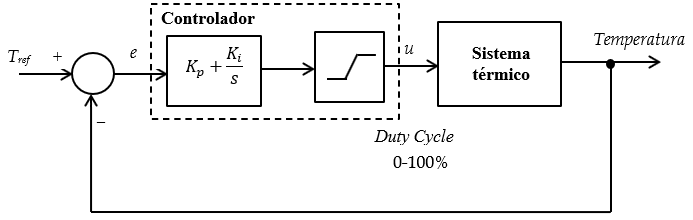




Para as experiências com o controlador **PI** utilize o sistema térmico 2 (sensor `S2`) do SERT. Neste caso, efetue o controlo do sistema durante um tempo de $t_{final}=600$ s. 


#### Ponto 1
Obtenha o comportamento do sistema SERT com um controlador **PI** para $K_p=5$  e $T_i=20,50,100$.

**a)**

Para cada valor da constante $T_i$ , apresente num gráfico a curva de resposta da temperatura do sistema térmico e num outro gráfico os correspondentes sinais de controlo $(u)$, valor da componente proporcional $(P)$ e valor da componente integrativa $(I)$. Explique os valores de cada um dos termos à medida que a temperatura sobe e estabiliza em torno da referência desejada. 

In [ ]:
# Coloque o código/comentários AQUI

# Variáveis de configuração
arduino = ArduinoBoard()
PeriodAmost   = 1 										# Periodo de Amostragem 
FinalTime     = 200.0									# Tempo de experiência
Amostras      = int(np.round(FinalTime/PeriodAmost+1))	# Numero de amostras
SinalControlo = np.zeros(Amostras)						# Lista para recolher info sobre Sinal de Controlo aplicado
YModelo       = np.ones(Amostras)*25.0					# Lista para recolher info sobre a variação de temperatura
Erro          = np.zeros(Amostras)						# Lista para recolher info sobre a variação de erro
TRef     	  = np.ones(Amostras)*50.0					# Lista que contem a temperatura de referencia
TInicial 	  = 23.0									# Temperatura inicial para fins de simulação
K   		  = 0.667									# Ganho do sistema obtido no guião anterior
tau 		  = 143.552									# Tau do sistema obtido no guião anterior
tauD 		  = 100.654									# TauD do sistema obtido no guião anterior


# Função do controlador PI
def ControloPI(Kp, Ki, Erro, integral) :
    return Kp * Erro + Ki * integral

# Função de saturação
def Saturacao(Kp, Ki, Error, integral):
    return min(100, max(0, ControloPI(Kp, Ki, Error, integral)))

# Função para controle PI
def ControloPI1(Kp, Ki):
    integral = 0  # Inicializa o termo integral
    for i in range(Amostras-1):
        YModelo[i] = arduino.T1()  # Leitura do valor do modelo (temperatura)
        
        Erro[i] = TRef[i] - YModelo[i]  # Calcula o erro
        
        # Acumula o erro para o termo integral
        integral += Erro[i] * PeriodAmost
        
        # Calcula o sinal de controle com base no controlador PI
        SinalControlo[i] = Saturacao(Kp, Ki, Erro[i], integral)
        
        arduino.write_S2(SinalControlo[i]/100)  # Envia sinal ao Arduino (controle proporcional + integral)
        
        time.sleep(PeriodAmost)  # Atraso para o próximo ciclo de controle

        # Debugging print statements
        print(f"KP = {Kp}, KI = {Ki}")
        print(f"Iteration {i}:")
        print(f"  YModelo[{i}] = {YModelo[i]}")
        print(f"  Erro[{i}] = {Erro[i]}")
        print(f"  Integral[{i}] = {integral}")
        print(f"  SinalControlo[{i}] = {SinalControlo[i]}")
        print(f"  SinalControlo[{i}] (scaled) = {SinalControlo[i]/100}")
        
    return TRef, YModelo, SinalControlo, Erro





**b)**

Esboce num gráfico as curvas de temperatura do sistema térmico e num outro gráfico os correspondentes sinais de controlo ($u$) para os diferentes valores da constante $T_i$ considerados. Explique o fenómeno que leva a saída a apresentar um "overshoot".

In [ ]:
# Coloque o código/comentários AQUI



**c)**	

Indique quais as consequências de adicionar um controlo integral ao sistema.

In [ ]:
# Insira os comentários AQUI




#### Ponto 2
Simule o sistema de controlo em malha fechada da temperatura usando um controlador **PI**, $C(s)=K_p+K_i/s$, conforme representado na figura seguinte. Para isso, utilize o modelo de primeira ordem com atraso identificado no Guião do Trabalho No. 1, com a função de transferência:

$$ G(s)=\frac{Y(s)}{U(s)}=\frac{Ke^{-\tau_Ds}}{τs+1} \tag{4}$$

e os parâmetros $(K, \tau, \tau_D)$ identificados do sistema SERT (sensor `S2`). 

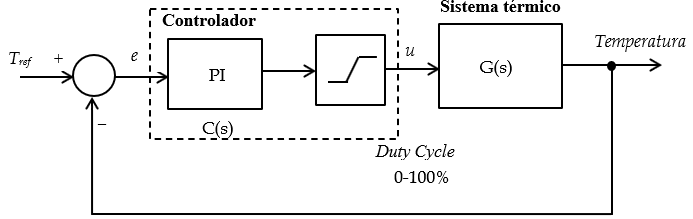

A correspondente equação diferencial é dada por:

$$ \tau \frac{dy(t)}{dt} + y(t) = K u(t-\tau_D)$$ 

**a)**

Apresente as curvas de resposta da temperatura do sistema simulado e dos correspondentes sinais de controlo ($u$) para os mesmos valores da constante  $T_i$  do controlador **PI** considerados no **Ponto 1**: $T_i=20,50,100$,  mantendo o ganho $K_p=5$.

In [ ]:
# Coloque o código/comentários AQUI




**b)**

Compare as curvas de simulação (temperatura e sinal de controlo) obtidas em **a)** com as respostas experimentais do **Ponto 1**. Comente eventuais diferenças existentes entre ambas as respostas. 

In [ ]:
# Coloque o código/comentários AQUI




#### Ponto 3
Faça a sintonia do controlador **PI** aplicando o método de Ziegler-Nichols 
(Z-N) em malha aberta. Para isso, utilize os parâmetros $(K,τ,τ_d)$ identificados do sistema SERT (sensor `S2`) referente ao modelo de primeira ordem com atraso (função de transferência (4)) identificado no Guião do Trabalho No. 1.

**a)**

Obtenha os parâmetros $(K_p, T_i)$ do controlador **PI**.

In [ ]:
# Coloque o código AQUI




**b)**

Apresente a curva de resposta da temperatura do sistema térmico e do correspondente sinal de controlo ($u$) para as constantes de sintonia obtidas em **a)**.

In [ ]:
# Coloque o código AQUI




**c)**

Comente o desempenho do controlador usando as constantes calculadas.

In [ ]:
# Insira os comentários AQUI




#### Ponto 4
Faça a sintonia do controlador **PI** aplicando o método IMC. Para isso, utilize os parâmetros $(K,τ,τ_d)$   identificados do sistema SERT (sensor `S2`) referente ao modelo de primeira ordem com atraso (função de transferência (4)) identificado no Guião do Trabalho No. 1.

**a)**

Obtenha os parâmetros $(K_p, T_i)$ do controlador **PI** para os valores de 
$τ_C=τ⁄10$, $τ_C=τ⁄5$  e $τ_C=τ⁄2$.

In [ ]:
# Coloque o código AQUI




**b)**

Apresente num gráfico as curvas de resposta da temperatura do sistema térmico e num outro gráfico os correspondentes sinais de controlo ($u$) para os parâmetros de sintonia calculados em **a)**.

In [ ]:
# Coloque o código AQUI




**c)**

Comente o desempenho do controlador usando as referidas sintonias.

In [ ]:
# Insira os comentários AQUI




#### Ponto 5
Existem diversos métodos para reduzir o efeito do *windup* verificado nas experiências anteriores. A figura seguinte apresenta um possível diagrama de um sistema em malha fechada com um controlador **PI** e um esquema
 *anti-windup*.

 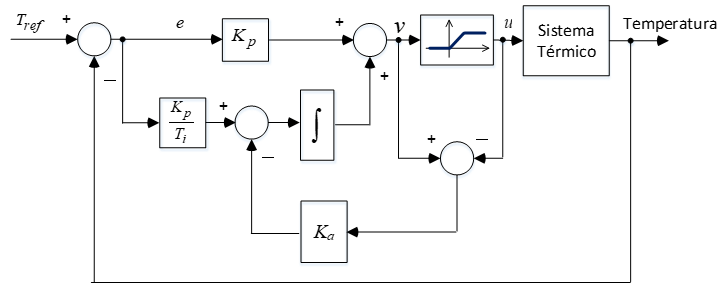

 O algoritmo do controlador **PI** com o esquema *anti-windup* é dado pelas seguintes equações:

$$ P(k) = K_p e(k)$$
$$ v(k) = P(k) + I(k)$$
$$ u(k) = sat(v(k),u_{min},u_{max})$$
$$I(k+1) = I(k) + \frac{K_P T}{T_i} e(k) + TK_a \left(u(k) - v(k)\right)$$
 

Para a realização das experiências, considere os parâmetros do controlador **PI** obtidos no **Ponto 3a)** usando o método de Ziegler-Nichols em malha aberta.

**a)**

Obtenha o comportamento do sistema SERT para os valores do ganho *anti-windup* $K_a = 0.02, 0.1, 0.2$. Para cada valor do ganho $K_a$, apresente num gráfico a curva de resposta da temperatura do sistema térmico e num outro gráfico os correspondentes sinal de controlo ($u$), valor da componente proporcional ($P$) e valor da componente integrativa ($I$). Explique a evolução de cada um dos sinais do sistema.

In [ ]:
# Coloque o código/comentários AQUI




**b)**

Compare os resultados com o esquema *anti-windup* e sem o esquema *anti-windup*. Esboce num gráfico as curvas de temperatura do sistema térmico e num outro gráfico os sinais de controlo ($u$) aplicados ao sistema. Comente os resultados obtidos.

In [ ]:
# Coloque o código/comentários AQUI


